## Homework 8

In [1]:
data_location = 'sqlite:///../../data/data.db'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle

## For this model I have decided to add more features such as maximum drawdown as well as the real close value (not the percent change)


In [3]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [4]:
def hourly_return(df):
    c = df.close
    returns = np.diff(df['close'])
    hourly_return = [0]
    for i in range (len(returns)):
        hourly_return.append(returns[i])
    
    return hourly_return

In [5]:
def maximum_drawdown(df):
    _open_ = df.open
    high = df.high
    low = df.low
    close = df.close
    
    max_DD = []
    for i in range (len(close)):
        roll_max = close[0:i].max()
        drawdown = close[0:i]/roll_max - 1
        max_DD.append(drawdown.min())
        
    return max_DD

In [6]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)
ohlc.shape

(11627, 9)

In [7]:
ohlc.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC


In [8]:
tokens = ohlc.token.unique()

In [31]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df).fillna(0),
            ret=df.close.pct_change(),
            close = df.close,
            max_dd = maximum_drawdown(df)
        )[['ts', 'vol', 'ret', 'close', 'max_dd']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret', 'close', 'max_dd'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [34]:
X.shape

(1057, 44)

In [35]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]

In [36]:
X.shape

(1056, 44)

In [13]:
y.describe()

count    1056.000000
mean       -0.000156
std         0.012010
min        -0.053429
25%        -0.007444
50%        -0.000503
75%         0.006740
max         0.048298
Name: ret_SOL, dtype: float64

In [14]:
from pandas.plotting import scatter_matrix, autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

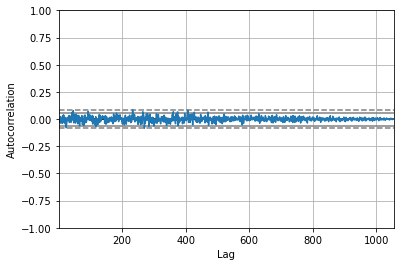

In [15]:
autocorrelation_plot(y[1:])

In [16]:
X.head()

,vol_BTC,ret_BTC,close_BTC,max_dd_BTC,vol_ETH,ret_ETH,close_ETH,max_dd_ETH,vol_USDT,ret_USDT,...,close_CRV,max_dd_CRV,vol_AAVE,ret_AAVE,close_AAVE,max_dd_AAVE,vol_COMP,ret_COMP,close_COMP,max_dd_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:00:00,0.0,NaN,61343.68,NaN,0.0,NaN,4290.16,NaN,0.0,NaN,...,4.4131,NaN,0.0,NaN,314.557,NaN,0.0,NaN,346.33,NaN
2021-11-01 01:00:00,0.0,0.004357,61610.93,0.000000,0.0,0.006874,4319.65,0.000000,0.0,0.0000,...,4.4163,0.000000,0.0,0.008043,317.087,0.000000,0.0,-0.002281,345.54,0.000000
2021-11-01 02:00:00,0.0,-0.004508,61333.17,-0.004338,0.0,-0.005322,4296.66,-0.006827,0.0,-0.0002,...,4.2759,-0.000725,0.0,-0.009171,314.179,-0.007979,0.0,-0.006020,343.46,-0.002281
2021-11-01 03:00:00,0.0,-0.012132,60589.06,-0.004508,0.0,-0.013126,4240.26,-0.006827,0.0,0.0001,...,4.2313,-0.031791,0.0,-0.013301,310.000,-0.009171,0.0,-0.022273,335.81,-0.008287
2021-11-01 04:00:00,0.0,-0.010186,59971.89,-0.016586,0.0,-0.010679,4194.98,-0.018379,0.0,0.0000,...,4.2504,-0.041890,0.0,-0.016452,304.900,-0.022350,0.0,-0.024002,327.75,-0.030376


In [17]:
pd.isnull(X).sum()

vol_BTC        0
ret_BTC        1
close_BTC      0
max_dd_BTC     1
vol_ETH        0
ret_ETH        1
close_ETH      0
max_dd_ETH     1
vol_USDT       0
ret_USDT       1
close_USDT     0
max_dd_USDT    1
vol_SOL        0
ret_SOL        1
close_SOL      0
max_dd_SOL     1
vol_ADA        0
ret_ADA        1
close_ADA      0
max_dd_ADA     1
vol_DOT        0
ret_DOT        1
close_DOT      0
max_dd_DOT     1
vol_AVAX       0
ret_AVAX       1
close_AVAX     0
max_dd_AVAX    1
vol_ATOM       0
ret_ATOM       1
close_ATOM     0
max_dd_ATOM    1
vol_CRV        0
ret_CRV        1
close_CRV      0
max_dd_CRV     1
vol_AAVE       0
ret_AAVE       1
close_AAVE     0
max_dd_AAVE    1
vol_COMP       0
ret_COMP       1
close_COMP     0
max_dd_COMP    1
dtype: int64

In [18]:
{col: y.corr(X[col]) for col in X.columns if X[col].dtype != 'object'}

{'vol_BTC': 0.028693550573573305,
 'ret_BTC': -0.01384862380414729,
 'close_BTC': 0.00961423248067582,
 'max_dd_BTC': 0.028209850543924372,
 'vol_ETH': 0.02357151289469288,
 'ret_ETH': 0.030649212659338242,
 'close_ETH': -0.013156263913303615,
 'max_dd_ETH': 0.02486101255167986,
 'vol_USDT': 0.006850180191310607,
 'ret_USDT': -0.04440085499052747,
 'close_USDT': -0.002192832465548241,
 'max_dd_USDT': 0.02993036774990084,
 'vol_SOL': 0.03485259726638473,
 'ret_SOL': -0.029855064193406503,
 'close_SOL': -0.02706251707149336,
 'max_dd_SOL': 0.032204055975395156,
 'vol_ADA': 0.038880233437007486,
 'ret_ADA': 0.00024928333961420914,
 'close_ADA': 0.013316912284826336,
 'max_dd_ADA': 0.03151873812054369,
 'vol_DOT': 0.05904076845167191,
 'ret_DOT': 0.008193946995455023,
 'close_DOT': 0.023782556386247843,
 'max_dd_DOT': 0.020338147959004144,
 'vol_AVAX': 0.04140851156078153,
 'ret_AVAX': 0.01691945028976705,
 'close_AVAX': -0.027830986994825287,
 'max_dd_AVAX': 0.040974587668279834,
 'vol_AT

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [20]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


In [21]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])
 

In [61]:
pip install scikit-learn==0.24.1

     |████████████████████████████████| 7.2 MB 4.4 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.0
    Uninstalling scikit-learn-0.24.0:
      Successfully uninstalled scikit-learn-0.24.0
Note: you may need to restart the kernel to use updated packages.


In [22]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.009508628138967716

In [23]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('model', Ridge(alpha=1.0))
])

evaluate_model(pipeline, X, y)

-0.00858418251603623

## Hyperparameter tuning

I decided to use a Lasso regression model instead of a Ridge regression and got a better score

In [45]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Lasso())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': [1, 5, 10, 20, 22, 30, 50],
    'model__alpha': [0.01, 0.1, 0.5,  1.]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.00857082 -0.00857082 -0.00857082 -0.00857082 -0.00857082 -0.00857082
         nan -0.00857082 -0.00857082 -0.00857082 -0.00857082 -0.00857082
 -0.00857082         nan -0.00857082 -0.00857082 -0.00857082 -0.00857082
 -0.00857082 -0.00857082         nan -0.00857082 -0.00857082 -0.00857082
 -0.00857082 -0.00857082 -0.00857082         nan]
  warnings.warn(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scale', StandardScaler()),
                                       ('pca', PCA()), ('model', Lasso())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.01, 0.1, 0.5, 1.0],
                         'pca__n_components': [1, 5, 10, 20, 22, 30, 50]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [46]:
search.best_params_

{'model__alpha': 0.01, 'pca__n_components': 1}

In [47]:
best_model = search.best_estimator_
evaluate_model(best_model, X, y)

-0.008570816681474391